# Coursework 1: 

## **Predicting gestational age at scan and birth for neonates from the developing Human Connectome Project**

In this coursework we ask you to put into practice the foundational theoretical skills and practical PyTorch coding techniques we taught you in weeks 1-4. This will test your understanding of how to design, create and train effective deep architectures in future, as well as how to perform appropriate pre-processing, data augmentation. optmisation and visualisation to maximise the accuracy, generalisability and interpretability of your models. We will expect you to:

1. Create custom DataSets from which you sample (separate train and validation) batches at random using a DataLoader
2. Design and implement appropriate augmentations so as to maximise the performance of your model on a left out set
4. Create a custom ResNet (with preactivation - [He 2016](https://arxiv.org/abs/1603.05027)) in order to perform perform regression. 
5. Write a training loop and optimise
6. Visualise the outputs of your network to evaluate whether your network is learning appropriate features.
 
**Deadline for the coursework is 5pm 28/02/2021.**


## **The Data**

The cerebral cortex is a thin layer of tissue at the outer surface of the brain, where most cells responsible for higher-order cognitive processing are found. The creation and maturation of these cells develops rapidly during fetal and early neonatal development (in the weeks and months just before and after birth), which leads to cortical folding and dramatic changes in the observed intensities of T1 and T2-weighted Magnetic Resonance Imaging (MRI). In this exercise you will use different MRI-derived metrics of cortical maturation to **predict the gestational age at scan _and_ at birth of babies scanned as part of the Developing Human Connectome Project** (dHCP, Makropoulos et al 2018). 

Since age at scan is a much stronger phenotype (easier to predict) we have set the notebook up such that you design and optimise your network for prediction of age at scan. Then modify/refine it for the task of age at birth. To achieve optimal performance on age at birth you will need to deconfound age at scan from the age at birth experiment

We will use metrics of cortical thickness, cortical curvature, cortical myelination and sulcal depth generated from mesh models of the cortical surface. While we will explore Geometric Deep Learning (for direct analysis of surface imaging data) in the last lecture of  course. Right now you will work with files which have been projected to 2D via the sphere:

<img src="https://drive.google.com/uc?id=1GLwUBYMQdOJPo3qLzzh518eoEcvlTOHj" alt="Drawing" style="width: 100px;"/>

Here A, shows the original cortical maps (for 3 of the 4 modalities), B shows the maps as you will view them with MatplotLib and C shows the type of regression result you might expect for prediction of age at scan if you trained your network long enough.


## **Getting started**

First mount your Google Drive and import all necessary packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
!pip3 install SimpleITK
!pip3 install imageio
!pip3 install scikit-image
!pip3 install seaborn


import random 
import SimpleITK as sitk
import time
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import torchvision
import scipy.misc
import imageio
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
from torch.utils.data.sampler import SubsetRandomSampler
from skimage.transform import resize
from torchvision import transforms, utils
import time
import seaborn as sns
!pip install torch-summary
from torchsummary import summary
import torch.optim as optim
from SimpleITK.SimpleITK import LabelMapMaskImageFilter

# # initialize network weights as a gaussian
# def weights_init(m):
#     classname = m.__class__.__name__
#     if classname.find('Conv') != -1:
#         m.weight.data.normal_(0.0, 0.02)
#     elif classname.find('BatchNorm') != -1:
#         m.weight.data.normal_(1.0, 0.02)
#         m.bias.data.fill_(0)

save_path = 'results'

if not os.path.exists(save_path):
    os.makedirs(save_path)






     |████████████████████████████████| 48.4 MB 1.3 MB/s 


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device) 

cuda


## **Accessing and loading the data set**

The data is available from this shared [GOOGLE DRIVE LINK](https://drive.google.com/drive/folders/1zqIXXtDTCF0M90C8q4eS809a0Zqxmtyh?usp=sharing). Once you access the link the folder should be accessible from your Google Drive. Note, it is possible to access data directly from a shared google drive/files so long as you first add it to your drive.

To do this:

- log into google drive and accept the invitation to share the folder/file. You should see the folder 'coursework1-data' under "shared with me" on the left side.
- Click on the folder / file so that they turn blue and are highlighted (do not enter the folder)
- Click on the three vertical dots and click "Add to My Drive" or "Add a Shortcut to Drive".

Labels are available [here](https://drive.google.com/file/d/1_W0ZW_VpfrIm6dxAXRf80iVErhE5qczn/view?usp=sharing) as a 2 column (pickled) pandas dataframe that defines 1) the subject id (`subj_id`) and 2) the target label: their gestational age at scan (`scan_pma`) **Download these labels and add them to your Drive** in the location indicated by the below path

#### **Now verify that you can successfully load and visualise the image files**

Try running the cell below to check everything is working. Take a clear note of the shape - it will require editing into the format PyTorch expects.

subject meta data subj_id        0
scan_pma    44.0
Name: 0, dtype: object
example shape  (240, 320, 4)


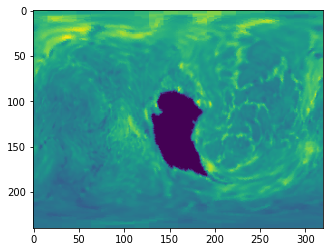

In [4]:
from sys import call_tracing
### cell/for testing file input/output/visualisation


dirname='/content/drive/MyDrive/AML/CW1/coursework1-data-2022-pma'
example_im=np.load(os.path.join(dirname,'2D_projection_L_sub-0.npy'))

meta_path='/content/drive/MyDrive/AML/CW1/meta_2022_pma.pkl'
label_df=pd.read_pickle(meta_path)

plt.imshow(example_im[:,:,0])
print('subject meta data', label_df.iloc[0])
print('example shape ', example_im.shape)  


# NOTE PyTorch is going to expect your data batches to have shape BxCxHxW 
# (Batch,Channels, Height, Width)!  


# **Exercise 1 Create a Custom DataSet and DataLoaders (15 Marks)**

### **Ex 1.1 Create data set class (8 marks)**

Complete a custom Dataset for this exercise. Make sure to return both images and their corresponding labels and return image tensors of the correct shape.


In [5]:
class CustomDataSet(torch.utils.data.Dataset):
  """
  note: we add option to split into train/val set (train = True)
  number of train samples, by setting train samples to 
  transform (for q4)
  """
  def __init__(self, data_folder_location, train=None, train_samples = 425, transform = None):
    self.data_folder_location = data_folder_location   
    self.images_folder = data_folder_location + '/coursework1-data-2022-pma'  
    self.labels_folder = data_folder_location + '/meta_2022_pma.pkl'
    self.transform= transform
    self.train = train
    self.train_samples = train_samples 
  
  def __len__(self):
    if self.train == None: 
      return len(os.listdir(self.images_folder))
    elif self.train==True:
      return self.train_samples
    else:
      return len(os.listdir(self.images_folder))-self.train_samples

  
  def __getitem__(self, idx):
    image = np.load(os.path.join( self.images_folder, f'2D_projection_L_sub-{idx}.npy'))
    label_df=pd.read_pickle(self.labels_folder)
    label = np.asarray(label_df.iloc[idx,1]).astype(float)
    image = transforms.ToTensor()(image).to(torch.float)
    label = torch.from_numpy(label).to(torch.float).unsqueeze(0)

   #IF WE WANT THE FULL DATASET
    if self.train == None: 
      sample = image, label

      if self.transform:
        sample = self.transform(image), label
      else: 
        sample = sample 

      return sample

    # IF WE WANT THE TRAIN SPLIT    
    elif self.train ==True:
      if idx <= self.train_samples: 
        sample = image, label

        if self.transform:
          sample = self.transform(image), label
        else: 
          sample = sample 
        
      else:
        sample = None

      return sample

    # IF WE WANT THE VALIDATION SPLIT
    elif self.train == False: 
      if idx <= self.train_samples: 
        sample = None
      
      else: 
        sample = image, label

      if self.transform:
        sample = self.transform(image), label
      else: 
        sample = sample

      return sample

**Ex 1.2 Test Dataset and create separate dataloaders for train and validation. (7 marks)**
-  print data set length (1 mark) 
- Create a Train Dataloader that samples from the first 425 subjects; batch size = 32 (2 marks)
- Create a Validation Dataloader that samples from the remaining 51 subjects; batch size = whole validation set (2 marks)
-  return one batch from the train dataloader; print shape _and_ plot ( 2 mark)



Length of dataset: 476
Length of training set: 425
Length of validation set: 51
Returning one batch (data): torch.Size([32, 4, 240, 320]), as expected this is (Batch, Channels, Height, Width)
Returning one batch (labels): torch.Size([32, 1]), as expected this is (Batch, 1)


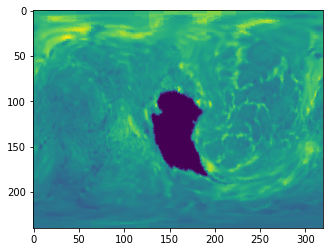

In [6]:
from numpy.lib.function_base import kaiser
# STUDENTS CODE - CREATE DATASET INSTANCE AND SEPARATE DATALOADERS FOR VALIDATION AND TEST
directory = '/content/drive/MyDrive/AML/CW1'
ds = CustomDataSet(directory)

#PRINT DATASET LENGTH
print(f'Length of dataset: {ds.__len__()}')


#CREATE TRAIN LOADER AND VALIDATION LOADER
train_set = CustomDataSet(directory, train=True, train_samples = 425)
print(f'Length of training set: {train_set.__len__()}')
val_set = CustomDataSet(directory, train=False)
print(f'Length of validation set: {val_set.__len__()}')
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle = False)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=51, shuffle = False)

#RETURN ONE BATCH, PRINT SHAPE AND PLOT
im_batch, lab_batch=next(iter(train_loader)) 
print(f'Returning one batch (data): {im_batch.shape}, as expected this is (Batch, Channels, Height, Width)')
print(f'Returning one batch (labels): {lab_batch.shape}, as expected this is (Batch, 1)') 

plt.imshow(im_batch[0,0])
plt.show()

**Total Ex. 2: 15 marks**

# **Exercise 2 - Create a pre-activation ResNet (15 marks)**



## **Ex 2.1 create a pre-activation residual block class (5 marks)**

Modify the residual block `ResidualBlock` class from the `3.1.Architectures_2021.ipynb` notebook to implement preactivation residual blocks following the implementation in the 2016 paper [He 2016](https://arxiv.org/abs/1603.05027)) 

**Note** if you are unable to implement this you may use the residual class from the tutorial notebook in order to complete the rest of the coursework

Image of the 'normal' vs 'proposed' ResBock architecture as seen in He 2016:

<img src="https://drive.google.com/uc?id=1Nygq9W7VrmF2h2z3FVzPrnd373N6MTHM" alt="Drawing" style="height: 50;"/>



In [7]:
# Students implement 2016 residual block  DECREASES IMAGE DIMENSIONS BY FACTOR 2, bATCH AND CHANNEL DIM ARE CONSTANT
# if this is too difficult just use the 2015 residual block from the architectures notebook 
class ResidualBlock(nn.Module):

    def __init__(self, channels1,channels2,res_stride=1):
        super(ResidualBlock, self).__init__()
        self.inplanes=channels1
        self.bn1=nn.BatchNorm2d(channels1)
        self.conv1=nn.Conv2d(channels1,channels2,kernel_size=3,stride=res_stride,padding=1, bias=False)
        self.bn2=nn.BatchNorm2d(channels2)
        self.conv2=nn.Conv2d(channels2,channels2,kernel_size=3,stride=1,padding=1, bias=False)
        
        if res_stride != 1 or channels2 != channels1:
            self.shortcut=nn.Sequential(nn.Conv2d(channels1,channels2,kernel_size=1,
                                                  stride=res_stride, bias=False),
                                        nn.BatchNorm2d(channels2))
        else:
            self.shortcut=nn.Sequential()
            

    def forward(self, x):
        
        out=self.bn1(x)
        out = F.relu(out)
        out=self.conv1(out)
        out = self.bn2(out)
        out = F.relu(out)
        out = self.conv2(out)
        out+=self.shortcut(x)

        return out
        
#testing the block
chan1 = 4
chan2 = 1
data=torch.rand((5,chan1,100,100))
blk2=ResidualBlock(chan1,chan2,2)
output=blk2(data)
print(data.shape, output.shape)

torch.Size([5, 4, 100, 100]) torch.Size([5, 1, 50, 50])


## **Ex 2.2. Implement a ResNet class (10 marks)**

Create a ResNet class such that reflects the basic structure of a typical ResNet; this includes : 

1. An initial strided convolutional layer with stride=2 and padding=1 (1 mark)
2. Any number of residual block layers (3 marks)
3. Linear layer to return output (for single output regression) (2 mark)
5. Implement these correctly in the forward function (4 marks)

**Hints**
 -  you can take inspiration from the original ResNet paper [He et al 2015](https://arxiv.org/pdf/1512.03385.pdf) for building the architecture.
 - While creating your ResNet class, try thinking about the complexity of your network in the context of the task your trying to solve and the size of your dataset.  


In [8]:
# STUDENTS CODE - CREATE RESNET NETWORK CLASS

#change num_blocks and num_strides and num_features to optimise later just get it running first

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_strides, num_features, in_channels):
        super(ResNet, self).__init__()
        self.in_planes = num_features[0] 

        #Initialise the network with a 3x3 conv and batch norm
        self.conv1=nn.Conv2d(in_channels, num_features[0], kernel_size=3, 
                             stride=2,padding=1,bias=False)
        self.bn1=nn.BatchNorm2d(num_features[0])

        #Using function make_layer() create 4 residual layers
        # num_blocks per layer is given by input argument num_blocks (which is an array)
        self.layer1 = self._make_layer(block, num_features[1], num_blocks, stride=num_strides[1])
        self.layer2 = self._make_layer(block, num_features[2], num_blocks, stride=num_strides[2])
        self.layer3 = self._make_layer(block, num_features[3], num_blocks, stride=num_strides[3])
        self.layer4 = self._make_layer(block, num_features[4], num_blocks, stride=num_strides[4])

        #create Linear layer
        self.linear = nn.Linear(num_features[4]*15,1) #15 = height dim
        
        #add a dropout layer
        self.dropout = nn.Dropout(0.7)

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
       
        # add downsampling residual block
        layers.append(block(self.in_planes, planes, stride))

        for i in np.arange(num_blocks-1):
            # add remaining residual blocks
            layers.append(block(planes, planes))
        
        self.in_planes = planes 
        return nn.Sequential(*layers)

    def forward(self, x):
      # initial convolution and batch norm
        out = F.relu(self.bn1(self.conv1(x)))
        #residual blocks 
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        #average pool (flattens spatial dimensions)
        out = F.avg_pool2d(out, 4)
        out = torch.flatten(out, 1)   
        out = self.dropout(out)
        out = self.linear(out)

        return out

**Total for section: 15**

# **Exercise 3 Train for prediction of postmenstrual age at scan (15 marks)**

Now that you have a basic network the first thing we will do is ask you to train your network to predict age at scan.

Age at scan is a strong phenotype since the appearance of babies brains change dramatically over the first few weeks of life. This experiment can therefore be seen as a baseline from which to optimise performance of your network prior to training on birth age (which is more difficult)


## **Ex 3.1 Initialise network, optimiser and loss function (5 marks)**
- print model to check the architecture (one option is to pip install and use the library torchsummary)


In [9]:
#we want our results to be reproducible so: 
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# STUDENTS CODE - CREATE INSTANCE OF NETWORK & PASS TO NETWORK
resnet = ResNet(ResidualBlock,3, [1,1,2,2,2], [64,64,128,256,512], in_channels=4)
resnet = resnet.to(device) 
summary(resnet, (4, 240, 320))

# CREATE LOSS OBJECT AND OPTIMISER
loss_fun = nn.MSELoss()
#optim = torch.optim.SGD(resnet.parameters(), lr = 1e-6, momentum=0.9)
optim = torch.optim.Adam(resnet.parameters(), lr=1e-5, weight_decay = 0.3)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 120, 160]        2,304
├─BatchNorm2d: 1-2                       [-1, 64, 120, 160]        128
├─Sequential: 1-3                        [-1, 64, 120, 160]        --
|    └─ResidualBlock: 2-1                [-1, 64, 120, 160]        --
|    |    └─BatchNorm2d: 3-1             [-1, 64, 120, 160]        128
|    |    └─Conv2d: 3-2                  [-1, 64, 120, 160]        36,864
|    |    └─BatchNorm2d: 3-3             [-1, 64, 120, 160]        128
|    |    └─Conv2d: 3-4                  [-1, 64, 120, 160]        36,864
|    |    └─Sequential: 3-5              [-1, 64, 120, 160]        --
|    └─ResidualBlock: 2-2                [-1, 64, 120, 160]        --
|    |    └─BatchNorm2d: 3-6             [-1, 64, 120, 160]        128
|    |    └─Conv2d: 3-7                  [-1, 64, 120, 160]        36,864
|    |    └─BatchNorm2d: 3-8             [-1, 64, 120, 160]       


## **Ex 3.2: Implement training and validation loops** (10 marks)

- Implement training loop (5 marks)
- Implement validation loop (3 marks)
- Plot validation and training loss (2 marks)

Train your network for 10 epochs. You should aim at a validation error around/below 1.0 and a smoothly decreasing loss curve.

In [10]:
epochs = 25
train_loss = []
val_loss=[]

for epoch in range(epochs): 
    # enumerate can be used to output iteration index i, as well as the data 
    resnet.train()
    for i, (data, labels) in enumerate(train_loader, 0):
        # STUDENTS TO DO 1.5 complete training loop
         
        data, labels = data.to(device), labels.to(device)
        optim.zero_grad()
        output=resnet(data)
        loss=loss_fun(output,labels)
        
        loss.backward()
        optim.step()
        
        # print statistics of loss tensor
        ce_loss = loss.item()
        train_loss.append(ce_loss)
        #if i % 10 == 0:
            #print('[%d, %5d] loss: %.3f' %
                 #(epoch + 1, i + 1, ce_loss))


    resnet.eval()
    for i, (data, label) in enumerate(val_loader):
      data, label =data.to(device), label.to(device)  
      pred = resnet(data)
      loss = loss_fun(pred, label)
      ce_loss = loss.item()
      val_loss.append(ce_loss)
      if i % 10 == 0:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, ce_loss))

[1,     1] loss: 1429.178
[2,     1] loss: 407.677
[3,     1] loss: 16.810
[4,     1] loss: 30.144
[5,     1] loss: 2.638
[6,     1] loss: 6.751
[7,     1] loss: 3.359
[8,     1] loss: 1.973
[9,     1] loss: 2.069
[10,     1] loss: 1.923
[11,     1] loss: 1.488
[12,     1] loss: 1.291
[13,     1] loss: 2.551
[14,     1] loss: 0.994
[15,     1] loss: 0.930
[16,     1] loss: 0.910
[17,     1] loss: 0.975
[18,     1] loss: 0.868
[19,     1] loss: 0.888
[20,     1] loss: 0.777
[21,     1] loss: 0.950
[22,     1] loss: 0.788
[23,     1] loss: 1.332
[24,     1] loss: 1.245
[25,     1] loss: 0.617


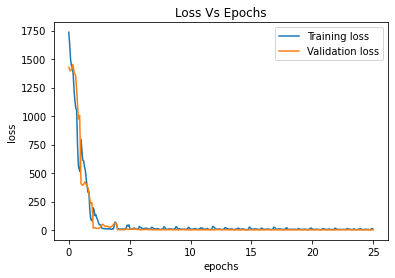

Final validation loss:1.192


In [11]:
#PLOTTING 
epochaxis1 = np.linspace(0, epochs, len(train_loss))
plt.plot(epochaxis1, train_loss, label = 'Training loss')
epochaxis2 = np.linspace(0, epochs, len(val_loss))

plt.plot(epochaxis2, val_loss, label = 'Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss Vs Epochs')
plt.legend()

plt.show()

#print(f'Final training loss:{round(train_loss[-1],3)}')
print(f'Final validation loss:{round(val_loss[-1],3)}')

**Total for section: 15** 

# **Exercise 4. Design Custom Augmentations & Optimise (20 marks)**

Now retrain but this time implement custom augmentations for your training data set

### **Example**

An example of class generating a class for image resizing is given below. It includes an `__init__` constructor (which sets parameters) and a `__call__`  function (which takes as input data and performs a transformation) 

```
class ResizeImage(object):
    
       def __init__(self, image_size):
            self.image_size = image_size

       def __call__(self, data):
            if len(self.image_size) == 2:
                image_resized = resize(data, (self.image_size[0], self.image_size[1]),
                                       anti_aliasing=True)
            else:
                image_resized = resize(data, (self.image_size[0], self.image_size[1], self.image_size[2]),
                                       anti_aliasing=True)

            return image_resized
```
You may also want to reference the official [PyTorch tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms)

We ask you to create two custom transform classes: 

1. to add Gaussian random noise; 
2. to simulate elastic deformations. 


## **Exercise 4.1 add a custom class for addition of Gaussian noise (4 marks)**

- Create a class which adds random gaussian noise to each datapoint of the image tensor (2 mark)
- set standard deviation as a tunable parameter (1 mark)
- test it on an example image 
and plot result (1 marks)

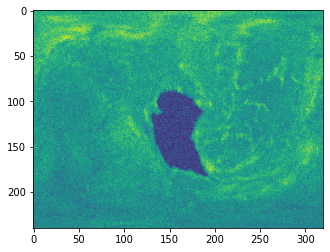

In [ ]:
# STUDENTS CODE - CREATE GAUSSIAN TRANSFORM CLASS
class AddGaussianNoise(object):
    def __init__(self, std=1.):
        self.std = std
        
    def __call__(self, data):
        return data + torch.randn(data.size()) * self.std 
    

# STUDENTS CODE - TEST TRANSFORM ON DATA EXAMPLE
im_batch, lab_batch=next(iter(train_loader))
GaussianNoise = AddGaussianNoise(std = 0.6)
noisyim = GaussianNoise(im_batch)
plt.imshow(noisyim[0,0])
plt.show()

## **Exercise Task 4.2 implement elastic augmentation**  (7 marks)

Implement a class for elastic augmentation

**hint** if you chose to adapt the example from week 3 (3_2_Dealing_with_Medical_Data_Notebook_solutions.ipynb) then make sure to account for the fact that this is a multi-channel 2D image rather than a single channel 3D image

Marks 
-  Implementation of a class for elastic 2D augmentation ( 5 marks)
-  set the displacement magnitude and deformation smoothness as a tunable parameter (1) 
-  apply and plot for a test image (1 marks)


In [ ]:
class ElasticDeformation(object): 
  """
  parameters: 
  deformation smoothness (num controlpoints)
  displacement magnitude (sigma)
  """
  def __init__(self, deformation_smoothness, displacement_mag):
    self.num_controlpoints = deformation_smoothness
    self.sigma = displacement_mag

  def create_elastic_deformation(self, image, num_controlpoints, sigma):
    # Create an instance of a SimpleITK image of the same size as our image 
    itkimg = sitk.GetImageFromArray(np.zeros(image.shape[1:3]),4)
    #print(itkimg.GetDimension()) will return 2 as expected (4 channnels)
    # This parameter is just a list with the number of control points per image dimensions
    trans_from_domain_mesh_size = [num_controlpoints] * itkimg.GetDimension()
    # We initialise the transform here: Passing the image size and the control point specifications
    bspline_transformation = sitk.BSplineTransformInitializer(itkimg, trans_from_domain_mesh_size)
    # Isolate the transform parameters: the bspline control points and spline coefficients
    params = np.asarray(bspline_transformation.GetParameters(), dtype=float)
    # Let's initialise the transform by randomly displacing each control point by a random distance (magnitude sigma)
    params = params + np.random.randn(params.shape[0]) * sigma
    bspline_transformation.SetParameters(tuple(params))
    return bspline_transformation

   
  def apply_elastic_deformation(self, image, num_controlpoints, sigma):
    # We need to choose an interpolation method for our transformed image, let's just go with b-spline
    resampler = sitk.ResampleImageFilter()
    resampler.SetInterpolator(sitk.sitkBSpline)
    # Let's convert our image to an sitk image - CHANNELS NEED TO BE PLACED LAST
    sitk_image = sitk.GetImageFromArray(np.swapaxes(np.transpose(image),0,1),4)
    # Specify the image to be transformed: This is the reference image
    resampler.SetReferenceImage(sitk_image)
    resampler.SetDefaultPixelValue(0)
    # Initialise the transform
    bspline_transform = self.create_elastic_deformation(image, num_controlpoints, sigma)
    # Set the transform in the initialiser
    resampler.SetTransform(bspline_transform)
    # Carry out the resampling according to the transform and the resampling method
    out_img_sitk = resampler.Execute(sitk_image)
    # Convert the image back into a python array
    out_img = np.swapaxes(np.transpose(sitk.GetArrayFromImage(out_img_sitk)),1,2)
    return out_img.reshape(image.shape) 
     
  def __call__(self, img, deformation_smoothness=5, displacement_mag=1):
    return self.apply_elastic_deformation(img, self.num_controlpoints, self.sigma)

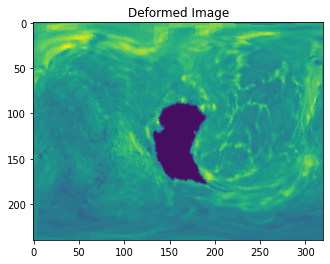

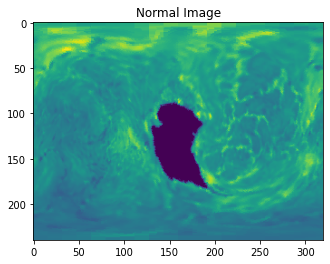

In [ ]:
image = im_batch[0]
ElDe = ElasticDeformation(deformation_smoothness = 5, displacement_mag = 10)
elastic_image = ElDe(image, deformation_smoothness = 5, displacement_mag = 10)
plt.imshow(elastic_image[0])
plt.title('Deformed Image')
plt.show()
plt.imshow(image[0])
plt.title('Normal Image')
plt.show()

## **Exercise 4.3  Compose the transform and re-train (4 marks)**

- Compose Gaussian and Elastic transforms (if you have them) into a single transform object using `torchvision.transforms.Compose` (1 mark)
- Regenerate train and validation datasets and dataloader; this time implementing augmentation for training only (2 marks)
- retrain (1 mark)



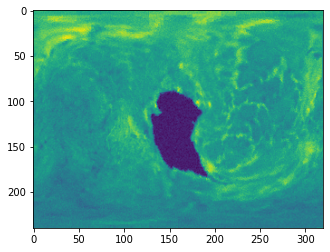

In [ ]:
# STUDENTS CODE - COMPOSE TRANSFORM

#set noise std  0.2, too much noise will significantly slow down training - we just want to prevent overfitting
#set displacement_mag = 1 (we dont want the images to look too different)
#it seems even slight augmentation significantly slows down the trainign process
transform = torchvision.transforms.Compose(([
            AddGaussianNoise(std = 0.2),
            ElasticDeformation(deformation_smoothness = 5, displacement_mag = 1)
          ]))

transformed_train_set = CustomDataSet(directory, train = True, transform = transform)
val_set = CustomDataSet(directory, train = False)

transformed_train_loader = torch.utils.data.DataLoader(transformed_train_set, batch_size=32, shuffle = False)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=51, shuffle = False)

#VIEW ONE BATCH TO MAKE SURE IT WORKS 
im_batch, lab_batch=next(iter(transformed_train_loader)) # view one batch
plt.imshow(im_batch[0,0])
plt.show()

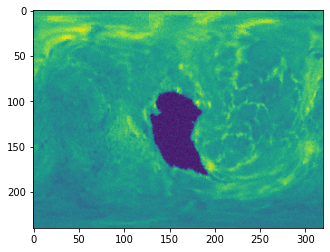

[1,     1] loss: 1701.402
[2,     1] loss: 1705.753
[3,     1] loss: 1723.264
[4,     1] loss: 1730.725
[5,     1] loss: 1732.901
[6,     1] loss: 1733.162
[7,     1] loss: 1733.320
[8,     1] loss: 1733.280
[9,     1] loss: 1733.287
[10,     1] loss: 1733.318


In [ ]:
#WE CREATE A NEW INSTANCE OF THE NETWORK AND TRAIN FROM SCRACTH 
#(this will allow for easier comparison with the modified model below)

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

resnet = ResNet(ResidualBlock,3, [1,1,2,2,2], [64,64,128,256,512], in_channels=4)
resnet = resnet.to(device)


epochs = 10
aug_train_loss = []
aug_val_loss=[]

for epoch in range(epochs): 
    #training
    resnet.train()
    for i, (data, labels) in enumerate(transformed_train_loader, 0):
        data, labels = data.to(device), labels.to(device)
        optim.zero_grad()
        output=resnet(data)
        loss=loss_fun(output,labels)
        loss.backward()
        optim.step()
        ce_loss = loss.item()
        aug_train_loss.append(ce_loss)
        #if i % 10 == 0:
            #print('[%d, %5d] loss: %.3f' %
                 #(epoch + 1, i + 1, ce_loss))

    #we evaluate too... 
    resnet.eval()
    for i, (data, label) in enumerate(val_loader):
      data, label =data.to(device), label.to(device)  
      pred = resnet(data)
      loss = loss_fun(pred, label)
      ce_loss = loss.item()
      aug_val_loss.append(ce_loss)
      if i % 10 == 0:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, ce_loss))

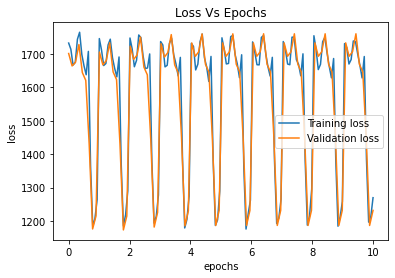

Final training loss:1269.548
Final validation loss:1231.485


In [ ]:
#PLOTTING 
epochaxis1 = np.linspace(0, epochs, len(train_loss))
plt.plot(epochaxis1, aug_train_loss, label = 'Training loss')
epochaxis2 = np.linspace(0, epochs, len(val_loss))

plt.plot(epochaxis2, aug_val_loss, label = 'Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss Vs Epochs')
plt.legend()
plt.show()

print(f'Final training loss:{round(aug_train_loss[-1],3)}{chr(10)}Final validation loss:{round(aug_val_loss[-1],3)}')

#free up some space 
torch.cuda.empty_cache()

## **Exercise 4.4: Optimise (5 marks)**

Try optimising the network further.

Explain your strategy. Describe how different strategies impact the training. Try to get an error below 0.9. 


**OPTIMISATION STRATEGIES**
"While data augmentation prevents the model from overfitting, some augmentation combinations can actually lead to underfitting. This slows down training which leads to a huge strain on resources like available processing time, GPU quotas, etc. Moreover, the model isn’t able to learn as much information to give accurate predictions which, again leads to high prediction errors."
 WE NEED TO FIX THIS


*   Do we have an appropriate learning rate? Our val loss is increasing so probably not!
   - decreasing our lr to 1e-6 results in a decreasing loss. However it decreases linearly (on avg). Hence our model is probably underfitting and so:
*   We should modify our degree of regularisation
    *   This is already being done by the transformations so... 
    *   Do we still need the dropout layer? remove to prevent underfitting 
    *   Should we remove regularisation in our optimiser (weight_decay)
         - yes, tried this and it made it better
*   Would we benefit from changing hyperparameters eg num_blocks and num_strides and num_features?
    *  Decreasing num_blocks slows down the rate at which the loss decreases epoch)
    *  Increasing num_blocks leads to clear improvement, but the loss still decreases significantly slower than for the non-augmented case. Increasing to more than 10 results in memory issues with cuda (despite having paid for colab pro...) 



In [ ]:
#CREATE NEW INSTANCE OF THE NETWORK THAT WE CAN OPTIMISE!
class ResNet2(nn.Module):
    def __init__(self, block, num_blocks, num_strides, num_features, in_channels, fc_features):
        super(ResNet2, self).__init__()
        self.in_planes = num_features[0]

        #Initialise the network with a 3x3 conv and batch norm
        self.conv1=nn.Conv2d(in_channels, num_features[0], kernel_size=3, 
                             stride=2,padding=1,bias=False)
        self.bn1=nn.BatchNorm2d(num_features[0])

        #Using function make_layer() create 4 residual layers
        # num_blocks per layer is given by input argument num_blocks (which is an array)
        self.layer1 = self._make_layer(block, num_features[1], num_blocks, stride=num_strides[1])
        self.layer2 = self._make_layer(block, num_features[2], num_blocks, stride=num_strides[2])
        self.layer3 = self._make_layer(block, num_features[3], num_blocks, stride=num_strides[3])
        self.layer4 = self._make_layer(block, num_features[4], num_blocks, stride=num_strides[4])

        #create Linear layer
        self.linear = nn.Linear(fc_features,1) #15 = height dim
        
        #add a dropout layer
        #self.dropout = nn.Dropout(0.7)

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
       
        # add downsampling residual block
        layers.append(block(self.in_planes, planes, stride))

        for i in np.arange(num_blocks-1):
            # add remaining residual blocks
            layers.append(block(planes, planes))
        
        self.in_planes = planes 
        return nn.Sequential(*layers)

    def forward(self, x):
      # initial convolution and batch norm
        out = F.relu(self.bn1(self.conv1(x)))
        #residual blocks 
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        #average pool (flattens spatial dimensions)
        out = F.avg_pool2d(out, 4)
        out = torch.flatten(out, 1)   
        #out = self.dropout(out)
        out = self.linear(out)

        return out

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# STUDENTS CODE - OPTIMISE NETWORK

resnet = ResNet2(ResidualBlock,11, [2,2,2,2,2], [64,64,128,256,512], in_channels=4, fc_features =2048)
resnet = resnet.to(device) 
optim = torch.optim.Adam(resnet.parameters(), lr=1e-6, weight_decay=0)

# CREATE LOSS OBJECT AND OPTIMISER
loss_fun = nn.MSELoss()
epochs = 30
new_aug_train_loss = []
new_aug_val_loss = []

for epoch in range(epochs): 
    resnet.train()
    for i, (data, labels) in enumerate(transformed_train_loader, 0):
        
        data, labels = data.to(device), labels.to(device)
        optim.zero_grad()
        output=resnet(data)
        loss=loss_fun(output,labels)  
        loss.backward()
        optim.step()
        
        ce_loss = loss.item()
        new_aug_train_loss.append(ce_loss)

    resnet.eval()
    for i, (data, label) in enumerate(val_loader):

        data, label =data.to(device), label.to(device)  
        pred = resnet(data)
        loss = loss_fun(pred, label)
        ce_loss = loss.item()
        new_aug_val_loss.append(ce_loss)

        if i % 10 == 0:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, ce_loss))    
            
print(f'Final training loss:{round(new_aug_train_loss[-1],3)}{chr(10)}Final validation loss:{round(new_aug_val_loss[-1],3)}')

[1,     1] loss: 1656.109
[2,     1] loss: 1427.904
[3,     1] loss: 989.832
[4,     1] loss: 579.865
[5,     1] loss: 315.213
[6,     1] loss: 154.961
[7,     1] loss: 69.211
[8,     1] loss: 30.550
[9,     1] loss: 14.419
[10,     1] loss: 8.757
[11,     1] loss: 7.134
[12,     1] loss: 6.293
[13,     1] loss: 5.713
[14,     1] loss: 5.315
[15,     1] loss: 4.792
[16,     1] loss: 4.409
[17,     1] loss: 4.074
[18,     1] loss: 3.658
[19,     1] loss: 3.323
[20,     1] loss: 3.086
[21,     1] loss: 2.893
[22,     1] loss: 2.783
[23,     1] loss: 2.630
[24,     1] loss: 2.574
[25,     1] loss: 2.532
[26,     1] loss: 2.443
[27,     1] loss: 2.301
[28,     1] loss: 2.288
[29,     1] loss: 2.263
[30,     1] loss: 2.320
Final training loss:14.454
Final validation loss:4.34


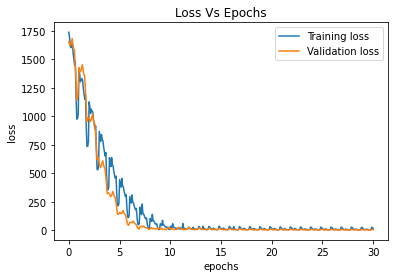

[1656.109375, 1620.9329833984375, 1630.6417236328125, 1682.9425048828125, 1601.99609375, 1577.6566162109375, 1389.8704833984375, 1141.5928955078125, 1177.883056640625, 1427.9044189453125, 1392.733154296875, 1406.66796875, 1454.8656005859375, 1379.586181640625, 1355.5557861328125, 1182.8277587890625, 954.2796630859375, 986.7105712890625, 989.8316040039062, 953.1990966796875, 974.8475952148438, 1020.4047241210938, 956.7084350585938, 933.436767578125, 800.942138671875, 620.8856201171875, 640.1177368164062, 579.8653564453125, 549.1815185546875, 572.8439331054688, 609.618408203125, 560.1068115234375, 539.9140625, 448.3164978027344, 321.2568359375, 327.9740905761719, 315.2134704589844, 294.30499267578125, 310.6200256347656, 339.7292175292969, 301.6072082519531, 285.7674865722656, 225.88121032714844, 140.5315399169922, 139.76353454589844, 154.96092224121094, 144.4691162109375, 150.4901885986328, 172.3738250732422, 144.94766235351562, 133.24180603027344, 99.18653869628906, 48.14715576171875, 4

In [ ]:
#PLOTTING 
epochaxis1 = np.linspace(0, epochs, len(new_aug_train_loss))
plt.plot(epochaxis1, new_aug_train_loss, label = 'Training loss')
epochaxis2 = np.linspace(0, epochs, len(new_aug_val_loss))

plt.plot(epochaxis2, new_aug_val_loss, label = 'Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss Vs Epochs')
plt.legend()
plt.show()

print(new_aug_val_loss)

*STUDENTS: EXPLAIN YOUR REASONING HERE*



**Total for section: 20 marks**

# **Exercise 5  Visualisation with occlusion (10 marks)**

Next use occlusion analysis to determine which parts of the image are most important for the prediction. Adapt the example on occlusion from the week 5 notebook on intepretability to instead work for regression (7)

Plot the resulting heatmap for the first 5 images from the validation batch. (3 mark)



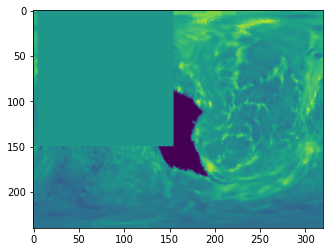

In [12]:
from math import ceil
# STUDENTS CODE - CREATE OCCLUSION FUNCTION FOR REGRESSION
def occlude_image(image, height_centre,width_centre,patch_size):
    ''' 
    Creates a copy of the image and occludes a patch 
    input:
    image (Pytorch tensor): image to be occluded
    model: Pytorch network model 
    height_centre=centre of patch on height dimension
    width_centre= centre of patch on width dimension
    patch_size: size of patch
    
    output: 
    probability
    '''

    occluded_image = image.detach().clone()
    height_start=height_centre-ceil(patch_size/2)
    width_start=width_centre-ceil(patch_size/2)

    if height_start <0:
      height_start=0
    if width_start < 0:
      width_start=0

    height_end=height_start+patch_size
    width_end=width_start+patch_size

    if height_end >= occluded_image.shape[1]:
      height_end=occluded_image.shape[1]-1
    if width_end >= occluded_image.shape[2]:
      width_end=occluded_image.shape[2]-1

    occluded_image[:,height_start:height_end,width_start:width_end]=0.5
    
    return occluded_image

image = im_batch[0]
occludedim=occlude_image(image, 59,80,150)
plt.imshow(occludedim[0,:,:])

In [13]:
# TESTING OCCLUSION ON 1 VALIDATION DATA SET 
im_batch, lab_batch=next(iter(val_loader))
patch_size=20
height_start=100
width_start=150

#check impact of occlusion on our error as opposed to prediction probability

#for the normal image
im_batch = im_batch.to(device)
lab_batch = lab_batch.to(device)
output = resnet(im_batch[0].unsqueeze(0))
loss = loss_fun(output, lab_batch[0].unsqueeze(0))
output = output.item()
error = loss.item()

#for the occluded image 
occluded_image = occlude_image(im_batch[0], height_start,width_start,patch_size)
occluded_image= occluded_image.to(device)
occluded_output = resnet(occluded_image.unsqueeze(0))
occ_loss = loss_fun(occluded_output, lab_batch[0].unsqueeze(0))
occ_error = occ_loss.item()

print('True label: {}, Original error: {}, Occluded error: {}'.format(lab_batch[0].item(), error ,occ_error)) 

True label: 44.0, Original error: 2.5226688385009766, Occluded error: 13.988211631774902


In [ ]:
resnet = ResNet(ResidualBlock,3, [1,1,2,2,2], [64,64,128,256,512], in_channels=4)
resnet.to(device)

In [14]:
# DEFINE OCCLUSION FUNCTION 

def occlusion(model, image, label, occ_size = 20,  occ_pixel = 10):
  heatmap = torch.zeros((image.shape[1],image.shape[2]))

  '''
       function to iterate occlusion mapping for all locations in an image
       in order to return a heatmap
       input:
            model - the trained model
            image - the input image to occlude
            label - the true image label
            occ_size - the patch size
            occ_pixel - the value to fill the patch with
      
      output:
           heatmap (torch array) - same shape as image,
                                 - value at each grid location =  label probabilities corresponding to result of occluding a patch centred at the corresponding image location

  '''
  
  for h in range(image.shape[1]):
      for w in range(image.shape[2]):
        if h % 4 == 0 and w % 4 == 0: #the code takes too long to run 
        #for individual pixels, so check for every 4 pixels 
            
            # occlude image for this patch
          occluded_image=occlude_image(image, h,w,occ_size)
          occluded_image, label = occluded_image.to(device), label.to(device)
            # make forward pass and return softmax probability
          output_occluded=resnet(occluded_image.unsqueeze(0))
          loss = loss_fun(output_occluded, label.unsqueeze(0))
          error = loss.item() 
          #setting the heatmap location to the error (we fill the regions but ensure no overlap) 
          heatmap[h-2:h+2, w-2:w+2] = error 

  return heatmap

#heatmap =  occlusion(resnet, image, lab_batch[0], occ_pixel = 1)
#ig = plt.figure()
#cbar_kws=dict(use_gridspec=False,pad=0.01,shrink=1)
#sns.heatmap(heatmap.detach().numpy(),xticklabels=False, yticklabels=False,cbar_kws=cbar_kws)
#plt.show()

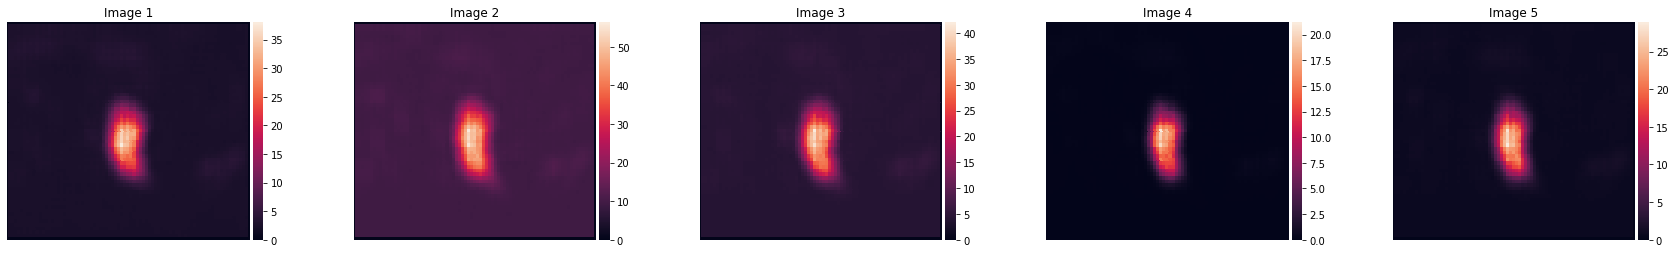

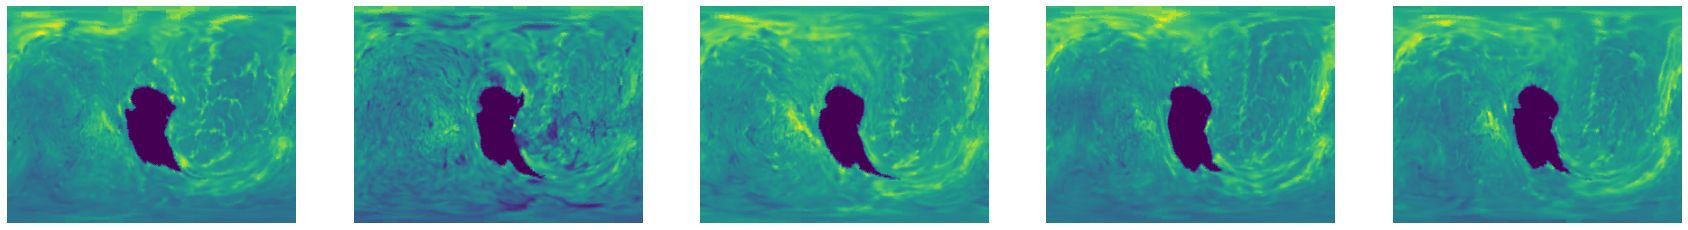

In [15]:
#TEST OCCLUSION FUNCTION ON FIRST 5 IMAGES IN VALIDATION BATCH
#NOTE: WHITE REGIONS INDICATE HIGHER IMPORTANCE 
im_batch, lab_batch=next(iter(val_loader))
num_images = 5
axes = []
plt.figure(figsize=(30,4))
for i in range(num_images): 
  image, label = im_batch[i], lab_batch[i]
  heatmap = occlusion(resnet, image, label, occ_size = 20,  occ_pixel = 10)
  plt.subplot(1,num_images,i+1)
  cbar_kws=dict(use_gridspec=False,pad=0.01,shrink=1)
  sns.heatmap(heatmap.detach().numpy(),xticklabels=False, yticklabels=False,cbar_kws=cbar_kws)
  plt.title(f'Image {i+1}')
plt.show()

#plotting the original images below
axes=[]
fig=plt.figure(figsize=(30,4))
for i in range(num_images):
    image = im_batch[i]
    axes.append(fig.add_subplot(1,num_images, i+1))
    plt.imshow(image[0])  
    plt.axis('off')   
plt.show()

**Total for section:total: 10**

# **Exercise 6: Birth Age Prediction (25 marks)**

In this last part of the coursework, you will try to solve a more difficult prediction task: prediction of the **birth age** of babies scanned as part of the Developing Human Connectome Project. For this, you will be using a new subset of the dhcp data with the same metrics as previously. 

Additionally, you will explore the problem of dealing with confounds in medical imaging; the task of birth age prediction being highly impacted by the apparence of the scan and thus the postmenstrual age at scan. Therefore, to improve predictions of birth age you will try to incorporate that information in the training process. 

Another key point to make here is that the data is imbalanced - while not a classification problem this can be addressed by noting that samples are much fewer for babies with birth ages below 37 weeks.

## **Ex 6.1 Create a new pipeline for Gestational Age predictions and train a network (5 marks)**

Data for gestational age prediction an be found [here](https://drive.google.com/drive/folders/1cJry-yrgsuVYajkmpBtbzz7zvCpSrfv4?usp=sharing). Labels can be found [here](https://drive.google.com/file/d/1HMrszbvJhUjLgZprKCpbOJQB92PBP2kl/view?usp=sharing). 

- First adapt your existing dataset class to return the image with GA as the label
- Create dataloaders for training and validation - with the first 411 subjects for training and the 51 remaining for valiation. 
- Train a model for 10 epochs. Observe the differences in performance compared to the previous task of gestational age at scan prediction

subj_id         0
scan_ga     40.14
scan_pma     44.0
Name: 0, dtype: object
40.14


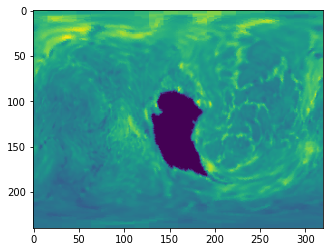

In [7]:
dirname='/content/drive/MyDrive/AML/CW1/coursework1-data-2022-ga'

example_im=np.load(os.path.join(dirname,'2D_projection_L_sub-0.npy'))

meta_path='/content/drive/MyDrive/AML/CW1/meta_2022_ga.pkl'
label_df=pd.read_pickle(meta_path)

plt.imshow(example_im[:,:,0])

print(label_df.iloc[0])

ar1 = np.asarray(label_df.iloc[0,1])
print(ar1)

In [14]:
# STUDENTS CODE -  create Datasets/Dataloaders for GA predictions
directory='/content/drive/MyDrive/AML/CW1/'

class CustomDataSetGA(torch.utils.data.Dataset):
  """
  note: we add option to split into train/val set (train = True)
  number of train samples, by setting train samples to 
  transform (for q4)
  """
  def __init__(self, data_folder_location, train=None, train_samples = 425, transform = None):
    self.data_folder_location = data_folder_location   
    self.images_folder = data_folder_location + '/coursework1-data-2022-pma'  
    self.labels_folder = data_folder_location + '/meta_2022_ga.pkl'
    self.transform= transform
    self.train = train
    self.train_samples = train_samples 
  
  def __len__(self):
    if self.train == None: 
      return len(os.listdir(self.images_folder))
    elif self.train==True:
      return self.train_samples
    else:
      return len(os.listdir(self.images_folder))-self.train_samples

  
  def __getitem__(self, idx):
    image = np.load(os.path.join( self.images_folder, f'2D_projection_L_sub-{idx}.npy'))
    label_df=pd.read_pickle(self.labels_folder)
    label = np.asarray(label_df.iloc[idx,1]).astype(float)
    image = transforms.ToTensor()(image).to(torch.float)
    label = torch.from_numpy(label).to(torch.float).unsqueeze(0)

   #IF WE WANT THE FULL DATASET
    if self.train == None: 
      sample = image, label

      if self.transform:
        sample = self.transform(image), label
      else: 
        sample = sample 

      return sample

    # IF WE WANT THE TRAIN SPLIT    
    if self.train ==True:
      if idx <= self.train_samples: 
        sample = image, label

        if self.transform:
          sample = self.transform(image), label
        else: 
          sample = sample 
        
      else:
        sample = None
        
      return sample

    # IF WE WANT THE VALIDATION (OR TEST) SPLIT
    else: 
      if idx <= self.train_samples: 
        sample = None
      
      else: 
        sample = image, label

      if self.transform:
        sample = self.transform(image), label
      else: 
        sample = sample

      return sample

train_set = CustomDataSetGA(directory, train=True, train_samples = 411)
print(f'Length of training set: {train_set.__len__()}')
val_set = CustomDataSetGA(directory, train=False)
print(f'Length of validation set: {val_set.__len__()}')

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle = False)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=65, shuffle = False)  #CHANGE BATCH SIZE HERE

Length of training set: 411
Length of validation set: 51


In [15]:
# STUDENTS CODE -  train to verify this is working
torch.cuda.empty_cache()
resnet = ResNet(ResidualBlock,3, [1,1,2,2,2], [64,64,128,256,512], in_channels=4)
resnet = resnet.to(device) 
loss_fun = nn.MSELoss()
optim = torch.optim.Adam(resnet.parameters(), lr=1e-5, weight_decay=0.3)

epochs = 10
new_train_loss = []

for epoch in range(epochs): 
    # enumerate can be used to output iteration index i, as well as the data 
    resnet.train()
    for i, (data, labels) in enumerate(train_loader, 0):
        # STUDENTS TO DO 1.5 complete training loop
         
        data, labels = data.to(device), labels.to(device)
        optim.zero_grad()
        output=resnet(data)
        loss=loss_fun(output,labels)
        
        loss.backward()
        optim.step()
        
        # print statistics of loss tensor
        ce_loss = loss.item()
        new_train_loss.append(ce_loss)
        if i % 10 == 0:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, ce_loss))
            
print(f'Final training loss is: {new_train_loss[-1]}')

[1,     1] loss: 1657.541
[1,    11] loss: 760.487
[2,     1] loss: 783.349
[2,    11] loss: 227.553
[3,     1] loss: 224.426
[3,    11] loss: 20.400
[4,     1] loss: 24.848
[4,    11] loss: 27.504
[5,     1] loss: 5.825
[5,    11] loss: 23.413
[6,     1] loss: 4.093
[6,    11] loss: 14.377
[7,     1] loss: 7.915
[7,    11] loss: 13.321
[8,     1] loss: 9.111
[8,    11] loss: 14.944
[9,     1] loss: 5.733
[9,    11] loss: 16.386
[10,     1] loss: 8.435
[10,    11] loss: 13.394
Final training loss is: 58.39360046386719


Does not train as smoothly as the pma only resnet. Looks like we might be overshooting the minima? Perhaps we should try a lower lr..

## **Ex 6.2 Create a new Dataset for Gestational Age predictions with confounds ( 5 marks)**

- Adapt the dataset to return 3 elements **[image, (birth age, scan age)]**
- Regenerate train and validation DataLoaders
- consider ways to address class imbalance

In [31]:
# STUDENTS CODE -  adapt Dataset to return birth age and scan age
# STUDENTS CODE -  create Datasets/Dataloaders for GA predictions
directory='/content/drive/MyDrive/AML/CW1/'

class CustomDataSet(torch.utils.data.Dataset):
  """
  note: we add option to split into train/val set (train = True)
  number of train samples, by setting train samples to 
  transform (for q4)
  """
  def __init__(self, data_folder_location, train=None, train_samples = 425, transform = None):
    self.data_folder_location = data_folder_location   
    self.images_folder = data_folder_location + '/coursework1-data-2022-pma'  
    self.labels_folder = data_folder_location + '/meta_2022_ga.pkl'
    self.transform= transform
    self.train = train
    self.train_samples = train_samples 
  
  def __len__(self):
    if self.train == None: 
      return len(os.listdir(self.images_folder))
    elif self.train==True:
      return self.train_samples
    else:
      return len(os.listdir(self.images_folder))-self.train_samples

  
  def __getitem__(self, idx):
    
    image = np.load(os.path.join( self.images_folder, f'2D_projection_L_sub-{idx}.npy'))
    label_df=pd.read_pickle(self.labels_folder)
    label = np.asarray(label_df.iloc[idx,1:3]).astype(float)
    image = transforms.ToTensor()(image).to(torch.float)
    label = torch.from_numpy(label).to(torch.float)

   #IF WE WANT THE FULL DATASET
    if self.train == None: 
      sample = image, label

      if self.transform:
        sample = self.transform(image), label
      else: 
        sample = sample 

      return sample

    # IF WE WANT THE TRAIN SPLIT    
    if self.train ==True:
      if idx <= self.train_samples: 
        sample = image, label

        if self.transform:
          sample = self.transform(image), label
        else: 
          sample = sample 
        
      else:
        sample = None
      return sample

    # IF WE WANT THE VALIDATION (OR TEST) SPLIT
    else: 
      if idx <= self.train_samples: 
        sample = None
      
      else: 
        sample = image, label

      if self.transform:
        sample = self.transform(image), label
      else: 
        sample = sample

      return sample
  
train_set = CustomDataSet(directory, train=True, train_samples = 411)
print(f'Length of training set: {train_set.__len__()}')
val_set = CustomDataSet(directory, train=False)
print(f'Length of validation set: {val_set.__len__()}')

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle = False)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=65, shuffle = False)
img, label = train_set.__getitem__(0)
print(f'Label: {label}')

Length of training set: 411
Length of validation set: 51
Label: tensor([40.1400, 44.0000])


CONSDIERING WAYS TO ADDRESS CLASS IMBALANCE:


1.   Upsampling -  samples are much fewer for babies with birth ages below 37 weeks, so we can use a sampler in our dataloader which upsamples samples for babies with birth ages < 37
Weighted random sampler would have been good but requires classes.... 

2.   in general, consensus seems to be that regression performs better on unweighted data...

3.   DICE loss



In [17]:
#ADDRESSING CLASS IMBALANCE

#dice loss
def dice_coeff(pred, target):
    """This definition generalize to real valued pred and target vector.
    This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """

    smooth = 1.
    epsilon = 10e-8

    # have to use contiguous since they may from a torch.view op
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(iflat * iflat)
    B_sum = torch.sum(tflat * tflat)

    dice = (2. * intersection + smooth) / (A_sum + B_sum + smooth)
    dice = dice.mean(dim=0)
    dice = torch.clamp(dice, 0, 1.0-epsilon)

    return  dice
"""
#WEIGHTED SAMPLING - use the previous dataloader
img, label = train_set.__getitem__(1)
print(label.item())


label_array = np.zeros(train_set.__len__())
label_array = label_array.reshape(411, 1)
print(label_array.shape)


count = 0
index_list = []
for i in range(train_set.__len__()):
  img, label = train_set.__getitem__(i)
  label = label.item()
  if label < 37: 
    count += 1
    label_array[i] = label
    index_list.append(i)

print(label_array.shape)
print(count)



weight_u37 = 1/count

weight_o37 = 1/(train_set.__len__())
"""

#for classification we could just create an array containing these two weights and use in a
#sampler = WeightedRandomSampler(array, array.size), this would then be used in the DataLoader

#not sure how to proceed in the case of regression since there are no classes.... 

'\n#WEIGHTED SAMPLING - use the previous dataloader\nimg, label = train_set.__getitem__(1)\nprint(label.item())\n\n\nlabel_array = np.zeros(train_set.__len__())\nlabel_array = label_array.reshape(411, 1)\nprint(label_array.shape)\n\n\ncount = 0\nindex_list = []\nfor i in range(train_set.__len__()):\n  img, label = train_set.__getitem__(i)\n  label = label.item()\n  if label < 37: \n    count += 1\n    label_array[i] = label\n    index_list.append(i)\n\nprint(label_array.shape)\nprint(count)\n\n\n\nweight_u37 = 1/count\n\nweight_o37 = 1/(train_set.__len__())\n'

## **Ex 6.3 Edit ResNet to deconfound Gestational Age predictions with age at scan (5 marks)**

Prediction of gestational age at birth is a more difficult task than scan age prediction. Indeed, this task is highly correlated to the PMA at scan. Therefore, to improve GA predictions [Fawaz et al 2021](https://www.biorxiv.org/content/10.1101/2021.12.01.470730v1) incorporated scan age as a confound into the model before the last linear layer (see Figure 4); while [Dahan et al 2021](https://openreview.net/pdf?id=mpp843Bsf-) added that information in the first stages of the architecture (Appendix B.2).

- Modify your ResNet model to incorporate scan age information into the model before the last linear layer. 



"For birth age prediction, an additional 1D convolution was used to incorporate scan age as a confound. It was necessary to include this as the term-equivalent scans of each neonate were acquired for both preterm and term neonates, scanned at a range of ages (37 - 45 weeks’ PMA), meaning that scan appearance is dependent on both age at birth and at scan. The resulting output was concatenated with the encoded features prior to the linear layer, as shown in the figure."

In [19]:
# STUDENTS CODE -  adapt ResNet to allow for deconfounding

class DeconfoundedResNet(nn.Module):
    def __init__(self, block, num_blocks, num_strides, num_features, in_channels):
        super(DeconfoundedResNet, self).__init__()
        self.in_planes = num_features[0] 

        #Initialise the network with a 3x3 conv and batch norm
        self.conv1=nn.Conv2d(in_channels, num_features[0], kernel_size=3, stride=2,padding=1,bias=False)
        self.bn1=nn.BatchNorm2d(num_features[0])

        #Using function make_layer() create 4 residual layers
        # num_blocks per layer is given by input argument num_blocks (which is an array)
        self.layer1 = self._make_layer(block, num_features[1], num_blocks, stride=num_strides[1])
        self.layer2 = self._make_layer(block, num_features[2], num_blocks, stride=num_strides[2])
        self.layer3 = self._make_layer(block, num_features[3], num_blocks, stride=num_strides[3])
        self.layer4 = self._make_layer(block, num_features[4], num_blocks, stride=num_strides[4])

        self.conv11 = nn.Conv1d(1,4, kernel_size = 1)

        #create Linear layer
        self.linear = nn.Linear(num_features[4]*15 +4,1) #15 = height dim
        #add a dropout layer
        self.dropout = nn.Dropout(0.7)

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
       
        # add downsampling residual block
        layers.append(block(self.in_planes, planes, stride))
        for i in np.arange(num_blocks-1):
            # add remaining residual blocks
            layers.append(block(planes, planes))
        
        self.in_planes = planes 
        return nn.Sequential(*layers)

    def forward(self, x, m):
      # initial convolution and batch norm
        out = F.relu(self.bn1(self.conv1(x)))
        #residual blocks 
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        #average pool (flattens spatial dimensions)
        out = F.avg_pool2d(out, 4)
        out = torch.flatten(out, 1)  
        out = out = self.dropout(out)

        m = self.conv11(m.unsqueeze(2))
        m = nn.ReLU()(m)
        m = m.reshape(m.shape[0],-1)
        
        out = torch.cat([out,m], dim=1)
        out = self.linear(out)
        
        return out

## **Ex 6.4 Train and optimise (10 marks)**

If you are unable to do the deconfounding just optimise for the network you have


In [25]:
resnet = DeconfoundedResNet(ResidualBlock,5, [1,1,2,2,2], [64,64,128,256,512], in_channels=4)
resnet = resnet.to(device) 
loss_fun = nn.MSELoss()
optim = torch.optim.Adam(resnet.parameters(), lr=1e-5, weight_decay=0.3)

In [26]:
# STUDENTS CODE -  train and optimise
#REMEMBER A DICE VALUE OF 1 IS THE BEST
epochs = 10
dice_values = []
dice_vals = []

for epoch in range(epochs): 
    # enumerate can be used to output iteration index i, as well as the data 
    resnet.train()

    for i, (data, labels) in enumerate(train_loader, 0):
        # STUDENTS TO DO 1.5 complete training loop
        label = labels[:,0:1]
        metadata = labels[:,1:2]
        data, label, metadata = data.to(device), label.to(device), metadata.to(device)
        optim.zero_grad()
        
        output=resnet(data, metadata)
        loss=1- dice_coeff(output,label)
        dice_value = dice_coeff(output, label).item()
        dice_values.append(dice_value)
        loss.backward()
        optim.step()
        
        # print statistics of loss tensor
        if i % 10 == 0:
            print('[%d, %5d] dice value: %.3f' %
                 (epoch + 1, i + 1, dice_value))
    #resnet.eval()
    #for i, (data, labels) in enumerate(val_loader):
      #label = labels[:,0:1]
      #metadata = labels[:,1:2]
      #data, label, metadata = data.to(device), label.to(device), metadata.to(device)
      #optim.zero_grad()
      #pred = resnet(data, metadata)
      #dice_value = dice_coeff(pred, label).item()
      #dice_vals.append(dice_value)

        #if i % 10 == 0:
          #print('[%d, %5d] dice value: %.3f' %
                #(epoch + 1, i + 1, dice_value))       
   
            
print(f'Final dice val:{round(dice_values[-1],3)}')        

[1,     1] dice value: 0.000
[1,    11] dice value: 0.088
[2,     1] dice value: 0.113
[2,    11] dice value: 0.278
[3,     1] dice value: 0.274
[3,    11] dice value: 0.457
[4,     1] dice value: 0.450
[4,    11] dice value: 0.623
[5,     1] dice value: 0.587
[5,    11] dice value: 0.727
[6,     1] dice value: 0.699
[6,    11] dice value: 0.796
[7,     1] dice value: 0.763
[7,    11] dice value: 0.842
[8,     1] dice value: 0.805
[8,    11] dice value: 0.863
[9,     1] dice value: 0.841
[9,    11] dice value: 0.889
[10,     1] dice value: 0.849
[10,    11] dice value: 0.907
Final dice val:0.956


*STUDENTS: EXPLAIN YOUR REASONING HERE*


1.   As before, we increase the number of blocks
2.   Since we arent using augmented data we can keep our regularisation (weight_decay) and learning rate of 1e-5



**Total for section: 25**